# Predicting Road Accident Risk
- Kaggle Competition (playground)
- Data Source: https://www.kaggle.com/competitions/playground-series-s5e10
- Competition metrics: RMSE

# Import Libraries / Constants

In [31]:
import polars as pl
import polars.selectors as cs
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from xgboost import XGBRegressor

import joblib  # to save trained models
import EDA_funcs as EDA  # my personal utility functions for EDA and feature engineeringb

import warnings

warnings.filterwarnings("ignore")

In [2]:
import plotly.io as pio

# Set plotly to produce static images (github size limit)
pio.renderers.default = "png"

In [3]:
# Constants
PLOT_FOLDER = Path("../plots")
MODELS_FOLDER = Path("../models")
PRED_FOLDER = Path("../predictions")
DATA_FOLDER = Path("../data")
SAMPLE_SIZE = 5000  # to subsample df for certain visualization

# Load data 

In [6]:
# Load data set
train = pl.read_csv(DATA_FOLDER / "train.csv")
train.glimpse()

Rows: 517754
Columns: 14
$ id                      <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ road_type               <str> 'urban', 'urban', 'rural', 'highway', 'rural', 'highway', 'highway', 'highway', 'rural', 'urban'
$ num_lanes               <i64> 2, 4, 4, 4, 1, 3, 1, 2, 3, 4
$ curvature               <f64> 0.06, 0.99, 0.63, 0.07, 0.58, 0.54, 0.04, 0.33, 0.63, 0.38
$ speed_limit             <i64> 35, 35, 70, 35, 60, 70, 45, 45, 25, 45
$ lighting                <str> 'daylight', 'daylight', 'dim', 'dim', 'daylight', 'night', 'night', 'daylight', 'dim', 'dim'
$ weather                 <str> 'rainy', 'clear', 'clear', 'rainy', 'foggy', 'foggy', 'foggy', 'clear', 'clear', 'clear'
$ road_signs_present     <bool> False, True, False, True, False, True, False, False, True, True
$ public_road            <bool> True, False, True, True, False, False, True, True, False, True
$ time_of_day             <str> 'afternoon', 'evening', 'morning', 'morning', 'evening', 'morning', 'morning', 'evening', 'ev

# General Exploration

In [7]:
# numeric variables
train.select(cs.numeric()).describe()

statistic,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
str,f64,f64,f64,f64,f64,f64
"""count""",517754.0,517754.0,517754.0,517754.0,517754.0,517754.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",258876.5,2.491511,0.488719,46.112575,1.18797,0.352377
"""std""",149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
"""min""",0.0,1.0,0.0,25.0,0.0,0.0
"""25%""",129438.0,1.0,0.26,35.0,1.0,0.23
"""50%""",258877.0,2.0,0.51,45.0,1.0,0.34
"""75%""",388315.0,3.0,0.71,60.0,2.0,0.46
"""max""",517753.0,4.0,1.0,70.0,7.0,1.0


- Since it's synthetic data from Kaggle, there's no NULL values.
- 517,754 rows of data
- Target variable (accident_risk) ranges between 0 and 1.

8


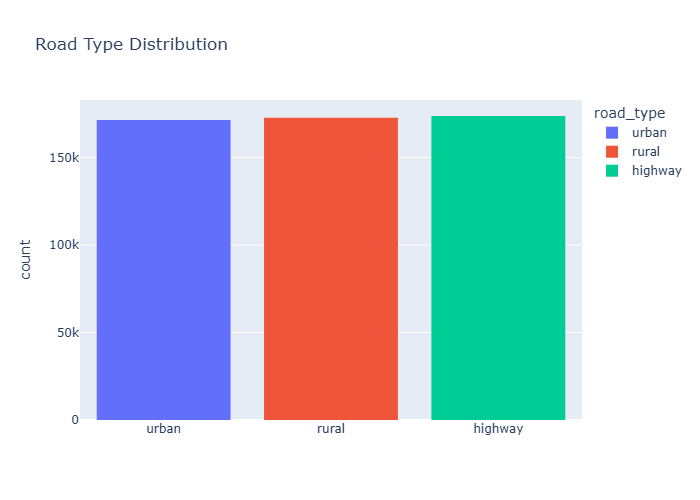

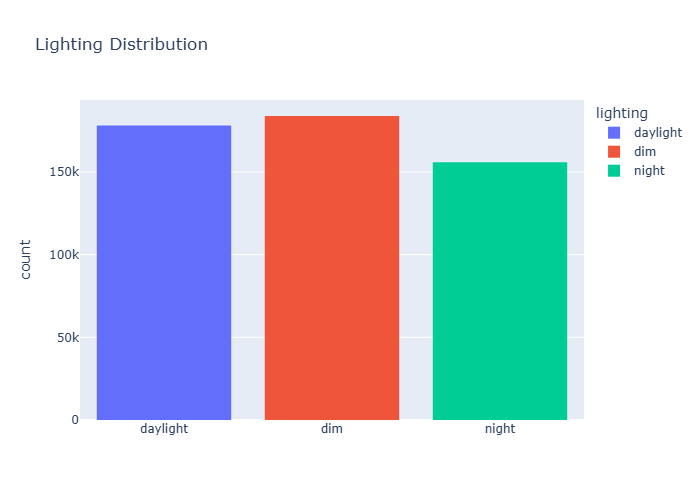

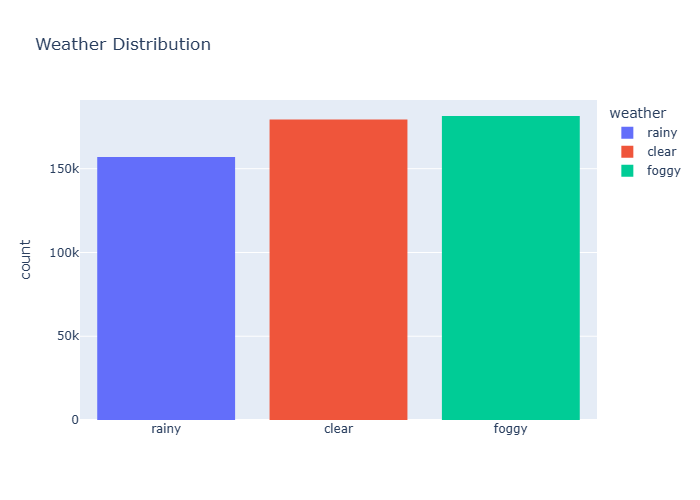

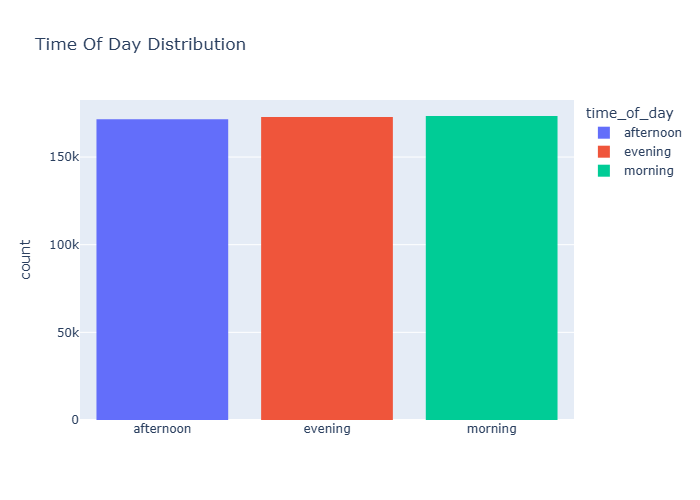

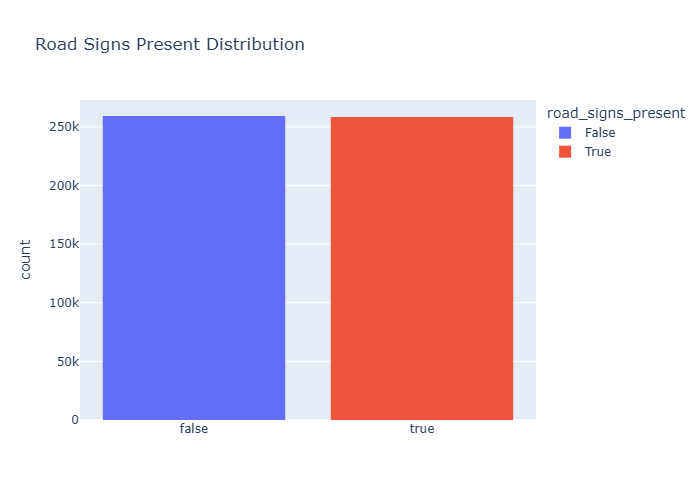

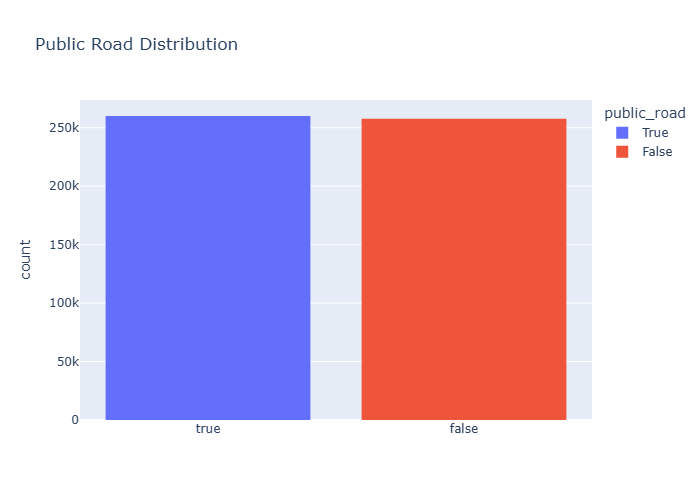

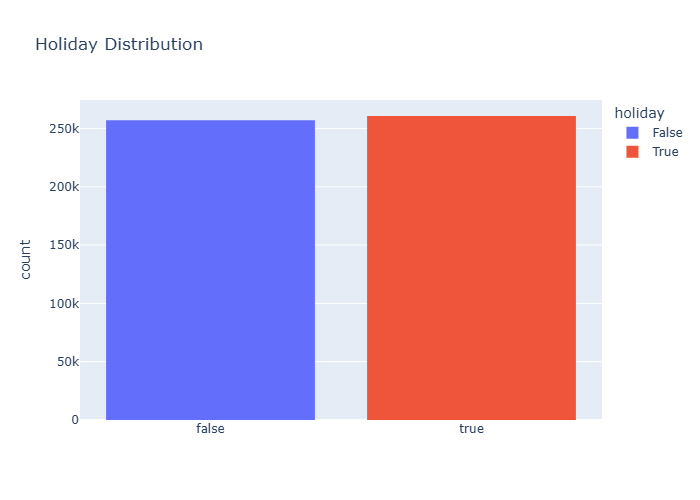

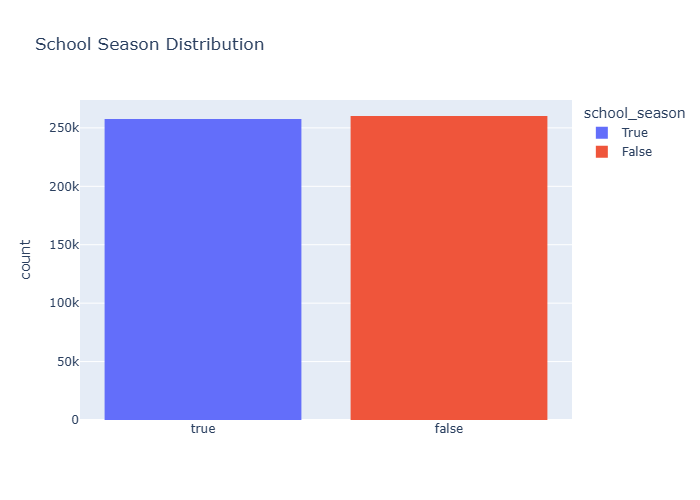

In [10]:
# Target variable
y_col = "accident_risk"

# Categorical and Boolean variables
cat_cols = train.select([cs.string(), cs.boolean()]).columns
print(len(cat_cols))  # 8
for col in cat_cols:
    fig = px.histogram(
        train,
        x=col,
        color=col,
        title=f"{col.replace('_', ' ').title()} Distribution",
    )
    fig.update_xaxes(title="")
    fig.show()

- Balanced dataset.
- 8 categorical variables

4


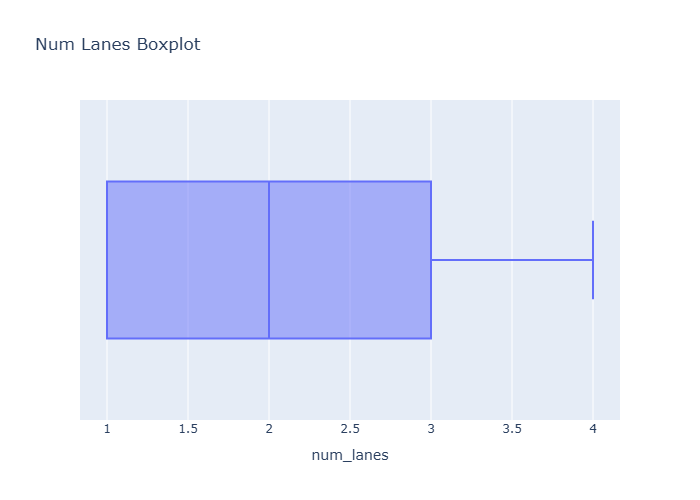

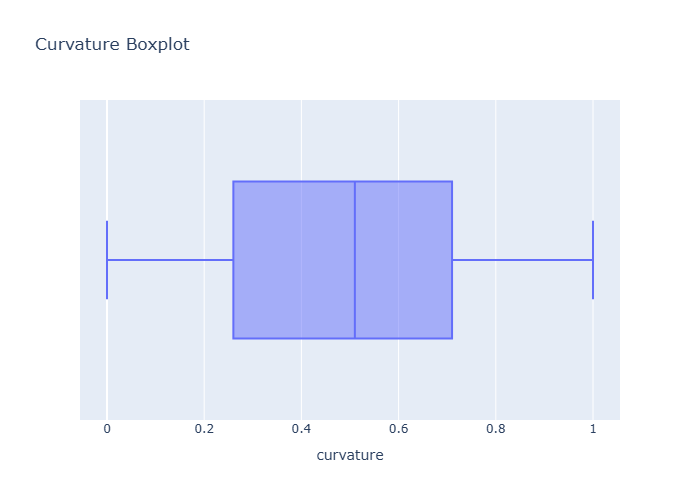

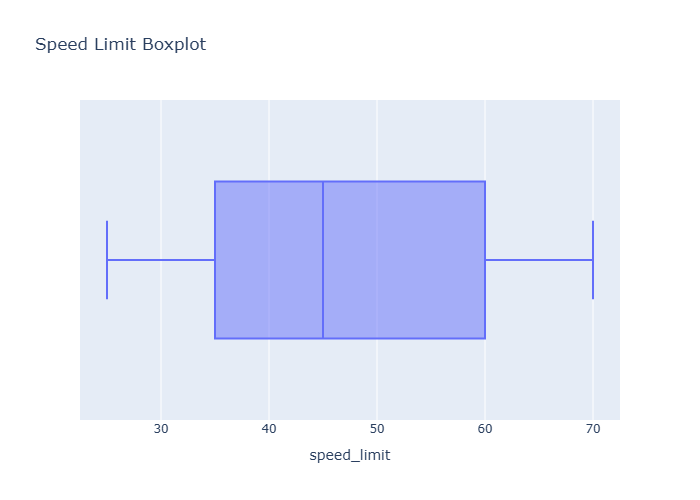

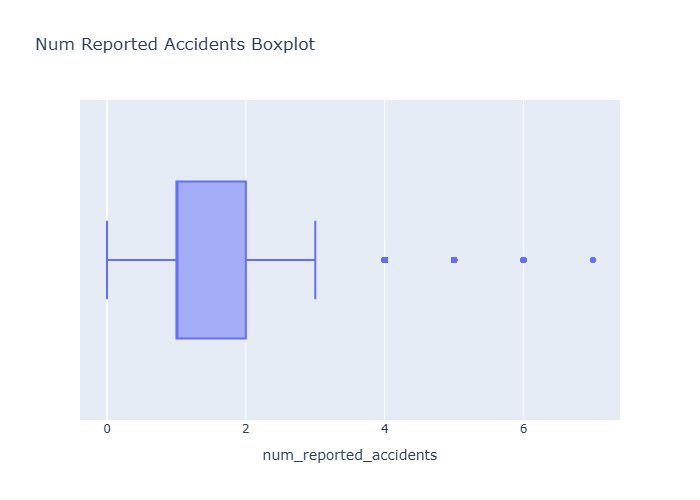

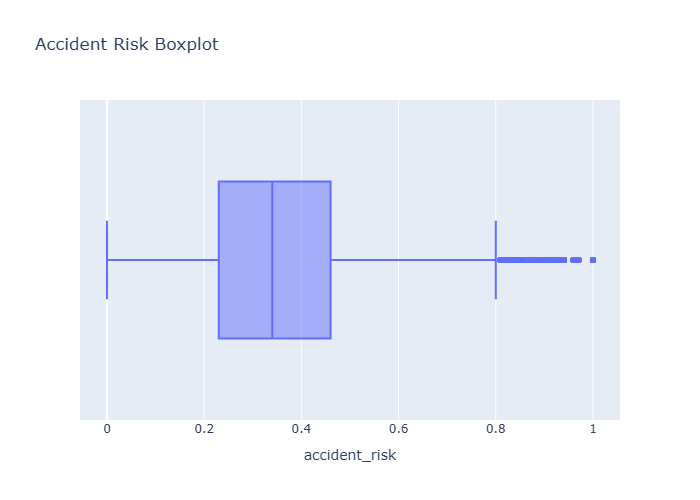

In [11]:
# Numeric variables
num_cols = train.select(cs.numeric()).select(pl.exclude("id", "accident_risk")).columns
print(len(num_cols))  # 4
for col in num_cols + [y_col]:
    px.box(train, x=col, title=f"{col.replace('_', ' ').title()} Boxplot").show()

- 4 numeric variables
- outliers from num_reported_accidents => should investigate further
- outliers from accident_risk (y)

## Correlations

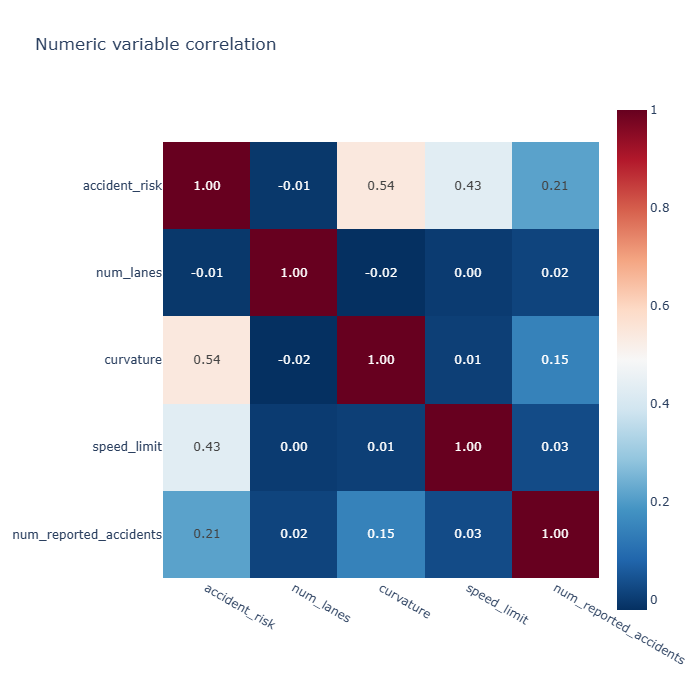

In [12]:
# correlation: numeric variables
correlation = train.select([y_col] + num_cols).corr()
fig = px.imshow(
    correlation,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    aspect="equal",
    y=correlation.columns,
    title="Numeric variable correlation",
)
fig.update_layout(
    width=700,  # Set explicit width
    height=700,  # Set explicit height
)
fig.update_traces(texttemplate="%{z:.2f}")
fig.show()
# fig.write_image(PLOT_FOLDER / "numeric_corr.png")

- Low correlations among x variables
- Correlation with y (from high to low): curvature > speed limit > num reported accidents
=> investigate more later
- Low correlation with y: num of lanes (-0.006)

For the column: Road Type


road_type,Mean accident rate,Std accident rate
str,f64,f64
"""highway""",0.35,0.166
"""rural""",0.35,0.167
"""urban""",0.357,0.166


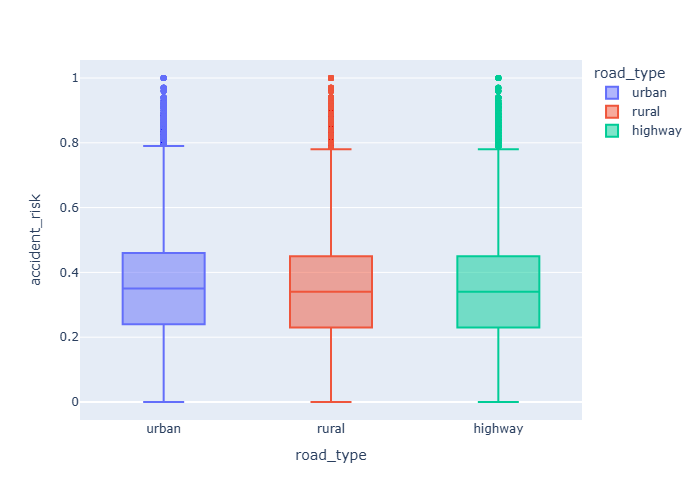

For the column: Lighting


lighting,Mean accident rate,Std accident rate
str,f64,f64
"""night""",0.47,0.158
"""dim""",0.3,0.142
"""daylight""",0.303,0.143


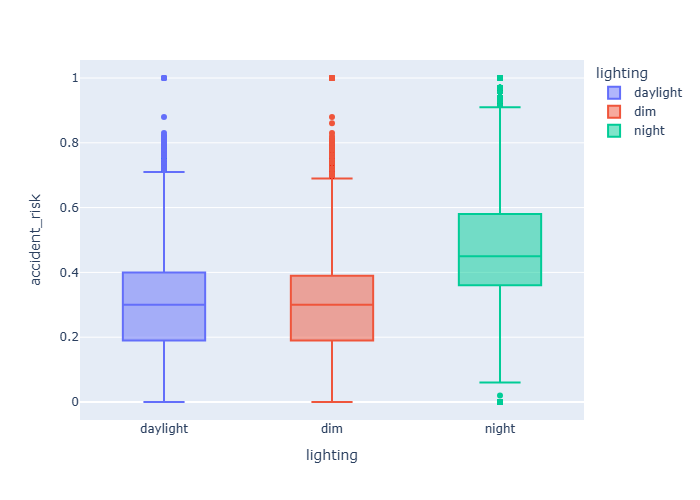

For the column: Weather


weather,Mean accident rate,Std accident rate
str,f64,f64
"""clear""",0.31,0.165
"""foggy""",0.386,0.168
"""rainy""",0.361,0.156


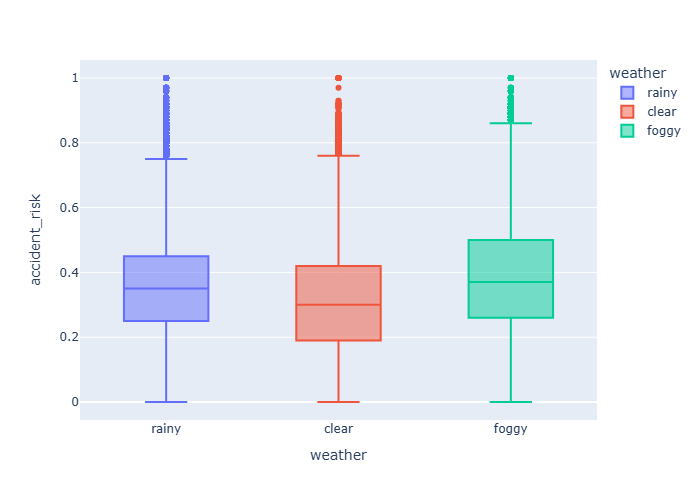

For the column: Time Of Day


time_of_day,Mean accident rate,Std accident rate
str,f64,f64
"""afternoon""",0.351,0.167
"""morning""",0.351,0.167
"""evening""",0.355,0.165


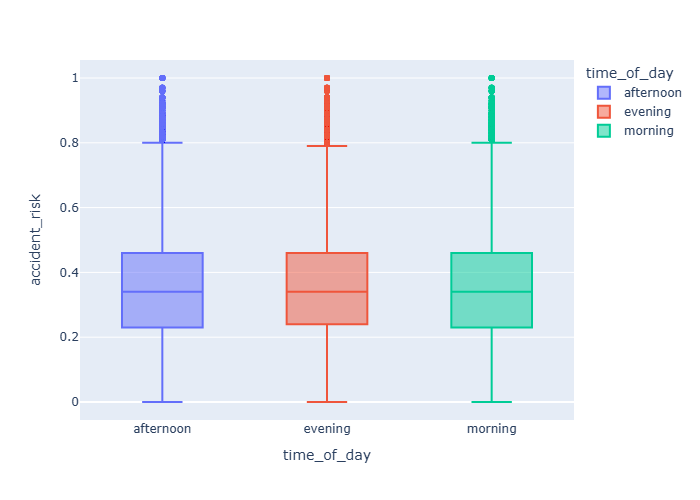

For the column: Road Signs Present


road_signs_present,Mean accident rate,Std accident rate
bool,f64,f64
false,0.352,0.166
true,0.352,0.167


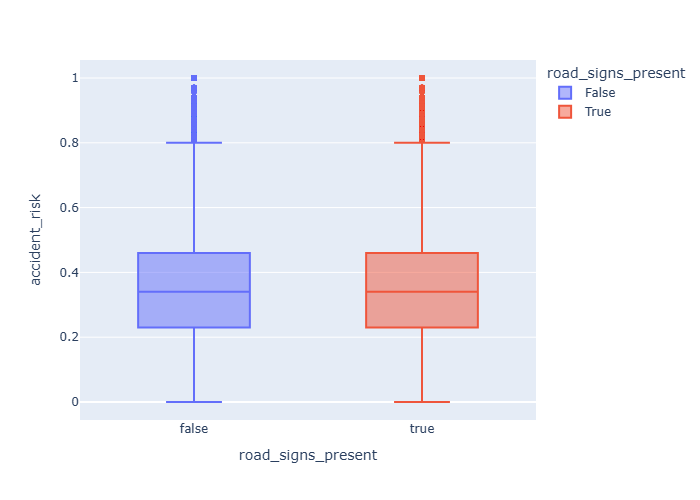

For the column: Public Road


public_road,Mean accident rate,Std accident rate
bool,f64,f64
false,0.347,0.165
true,0.358,0.168


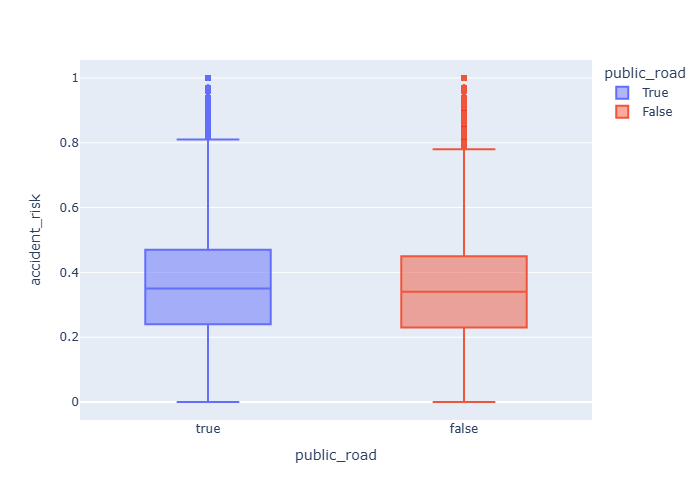

For the column: Holiday


holiday,Mean accident rate,Std accident rate
bool,f64,f64
false,0.344,0.165
true,0.361,0.168


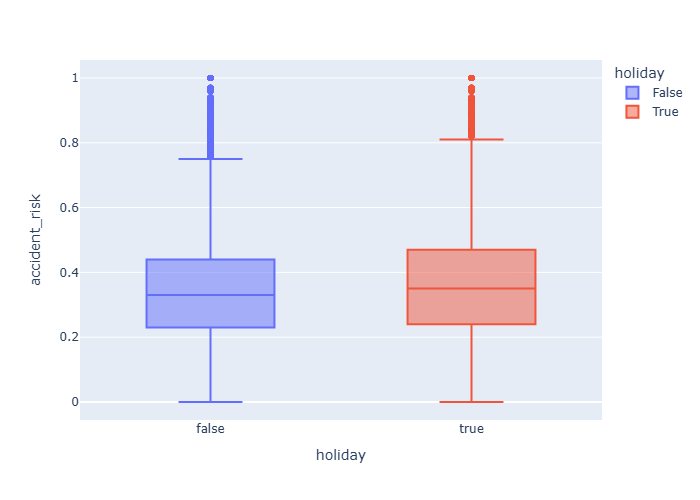

For the column: School Season


school_season,Mean accident rate,Std accident rate
bool,f64,f64
false,0.353,0.167
true,0.352,0.166


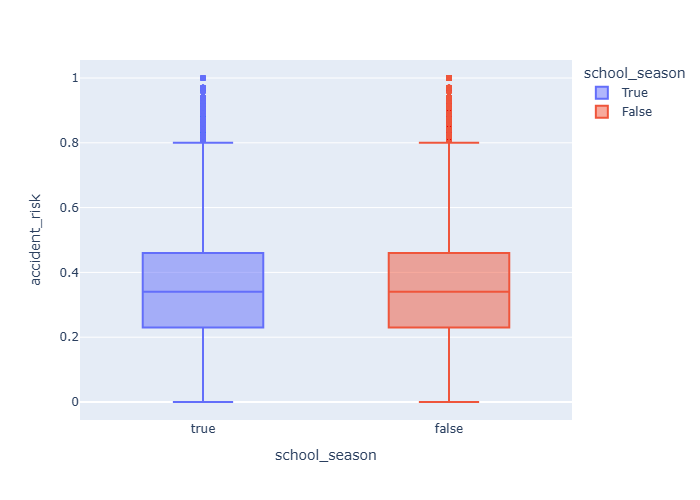

In [13]:
# y vs categorical variables
for col in cat_cols:
    print(f"For the column: {col.replace('_', ' ').title()}")
    mean = train.group_by(col).agg(
        pl.col(y_col).mean().round(3).alias("Mean accident rate"),
        pl.col(y_col).std().round(3).alias("Std accident rate"),
    )
    display(mean)
    px.box(train, x=col, y=y_col, color=col).show()

1. From the above, we identify the following strong candidates:
- road type: urban
- lighting: night
- weather: foggy, rainy
2. Moderate candidates:
- time of day: evening
- holiday: True
3. No effects:
- road signs present
- public road
- school season 

# Baseline Modeling

In [14]:
# Prepare data for sklearn modelings
X = train.select(num_cols + cat_cols).to_dummies(cat_cols).to_numpy()
y = train.select(y_col).to_numpy()
# 5 fold cross validation
kfold = KFold(5, shuffle=True, random_state=42)

In [15]:
# Define baseline regression models
# For Ridge and Lasso regressions, I first use RidgeCV/LassoCV
# to determine the best regularization parameters
ridge_model = Ridge(alpha=1)
lasso_model = Lasso(alpha=0.01)
rf_model = RandomForestRegressor(
    n_estimators=100,
    criterion="squared_error",
    n_jobs=-1,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
)
xgb_model = XGBRegressor(
    n_estimators=100,
    criterion="squared_error",
    n_jobs=-2,
    random_state=42,
)

In [16]:
models = [ridge_model, lasso_model, xgb_model]
# exclude rf_model for faster result (rf_model has slightly worse performance than xgboost here)
for model in models:
    EDA.cv_quick_score_regression(estimator=model, X=X, y=y, cv=kfold)



====== Start =======
Model: Ridge(alpha=1)
R2: 0.8049492367335329
MSE: 0.00540170991354246
MAE: 0.058354362400830806
====== Finish ======




====== Start =======
Model: Lasso(alpha=0.01)
R2: 0.7187314456886372
MSE: 0.007789506678258162
MAE: 0.06999052428259368
====== Finish ======




====== Start =======
Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, criterion='squared_error', device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
 

## Baseline Performance
1. Ridge Regression
- MSE: 0.0054
- R2: 0.8049
2. Lasso Regression
- MSE: 0.0077
- R2: 0.7187
3. Random Forest
- MSE: 0.0031
- R2: 0.8862
4. XGBoost
- MSE: 0.0031
- R2: 0.8861
5. Note:
- Expected behavior (trees >> linear regressions)
- Ridge regression >> Lasso regression

# Feature Engineering

In the following section, I will: 
1. Create new features (based on the initial EDA/intuition)
2. Run Ridge Regression (if it works then XGBoost) [for efficiency]
3. Compare the result of regular features vs new features
- See EDA_funcs for custom functions src


## Curvature: explore

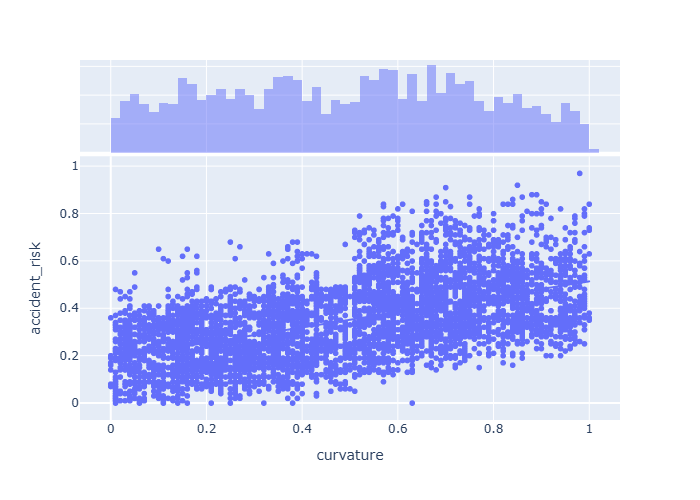

In [17]:
px.scatter(
    train.sample(n=SAMPLE_SIZE),
    x="curvature",
    y=y_col,
    marginal_x="histogram",
    trendline="ols",
)

- Clear and strong linear relationship
- At the first glance, there's no higher order relationship present

## Abnormal reported accidents

abnormal_reported,accident_risk
bool,f64
false,0.350701
true,0.678313


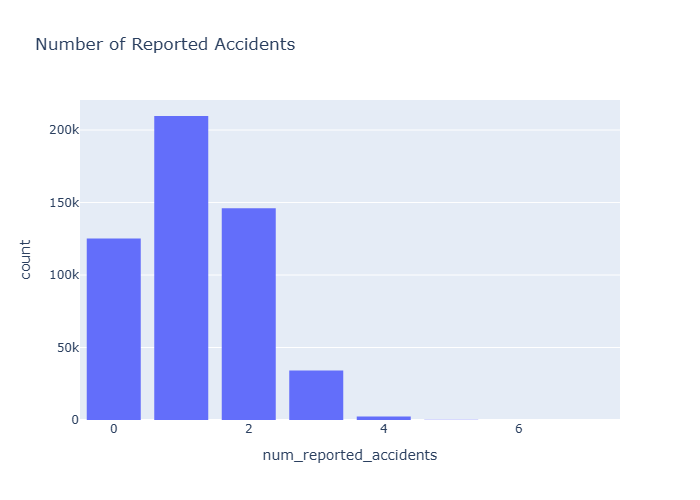

In [18]:
# Use 4 to create a threshold
table = (
    train.select(["num_reported_accidents", y_col])
    .with_columns((pl.col("num_reported_accidents") >= 4).alias("abnormal_reported"))
    .group_by("abnormal_reported")
    .agg(pl.mean(y_col))
)
display(table)
# Plot num reported accidents histogram
fig = px.histogram(
    train, x="num_reported_accidents", title="Number of Reported Accidents"
)
fig.update_layout(bargap=0.2)  # 0.2 = 20% gap
fig.show()

- Indeed, there's a huge categorical difference when num_reported_accidents is divided by this threshold.
- However, there are very few num_reported_accidents that are greater than equal to 4. To better judge the variable, we use the threshold 3 instead.

In [ ]:
new_train = train.with_columns(
    (pl.col("num_reported_accidents") >= 3).alias("abnormal_reported")
)
# turns pl.DataFrame into a trainable np.ndarray drops the id column and y column automatically
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
)

Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.004991998436007078
The model improves by 0.000409711477535382 (7.58%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031527351043748077
The model degrades by 1.5659003255652157e-07(0.00%)


- Huge improvement for ridge regression, no difference from xgboost.
- Makes sense since Ridge regression struggles to capture categorical/threshold type effects
- **New feature:** num_reported_accidents >= 3  

## High Speed Limit

In [20]:
train.group_by("speed_limit").agg(pl.col(y_col).mean().alias("Mean")).sort(
    "Mean", descending=True
)

speed_limit,Mean
i64,f64
60,0.466589
70,0.451436
45,0.292802
25,0.291834
35,0.28787


- Clearly, speed limit should be split to two groups: {60, 70} and {25, 35, 45}, representing low speed limit and high speed limit group

In [21]:
new_train = train.with_columns((pl.col("speed_limit") > 50).alias("high_speed_limit"))
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
);

Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.0037559573839203208
The model improves by 0.001645752529622139 (30.47%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031527351043748077
The model degrades by 1.5659003255652157e-07(0.00%)


- Significant improvement in Ridge model, no improvement from XGBoost
- **New Feature:** speed_limit > 50 (high_speed_limit)

## Combining High Speed Limit & Categorical variables

high_speed_limit,Mean accident rate
bool,f64
false,0.290829
true,0.45948


Column: road_type


road_type,true,false
str,f64,f64
"""rural""",0.457979,0.287576
"""urban""",0.462085,0.29604
"""highway""",0.458353,0.288974


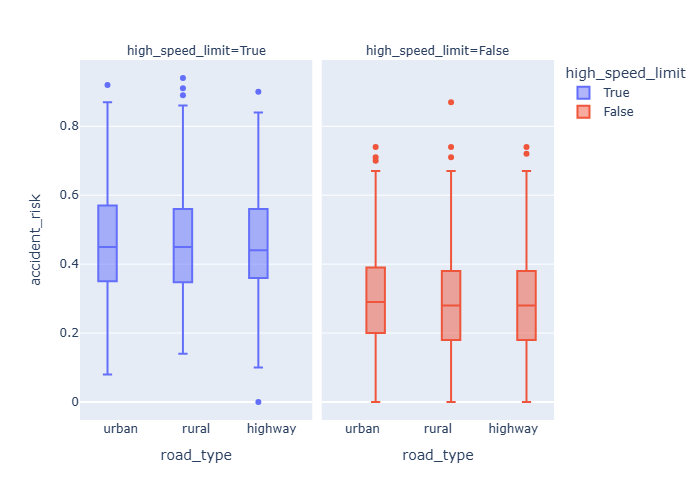

Column: lighting


lighting,true,false
str,f64,f64
"""daylight""",0.406135,0.233951
"""dim""",0.405776,0.233741
"""night""",0.622391,0.40545


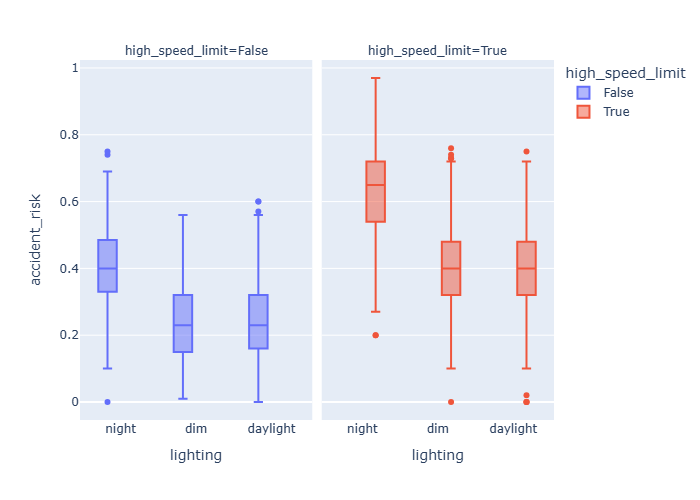

Column: weather


weather,false,true
str,f64,f64
"""foggy""",0.320013,0.503136
"""clear""",0.237789,0.410212
"""rainy""",0.310534,0.476835


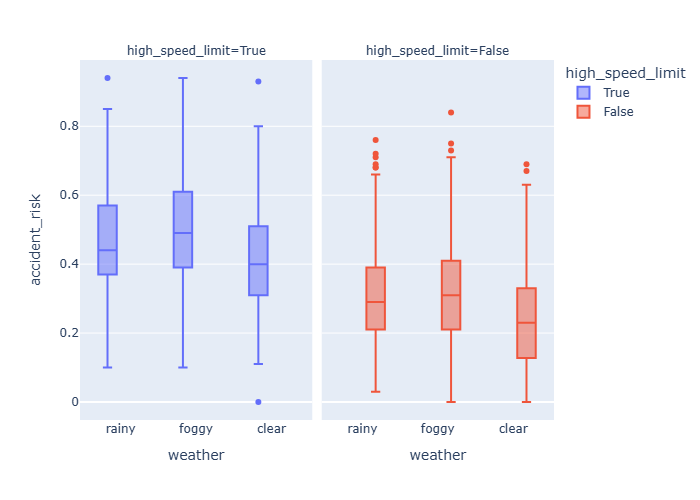

Column: time_of_day


time_of_day,true,false
str,f64,f64
"""morning""",0.458922,0.289524
"""evening""",0.460484,0.294073
"""afternoon""",0.459032,0.288874


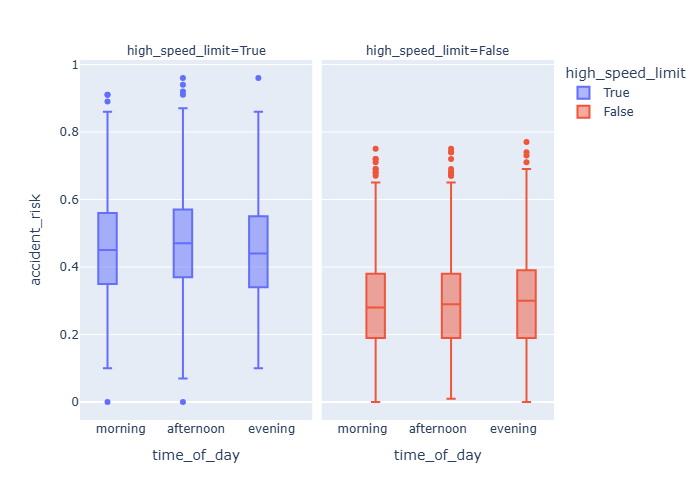

Column: road_signs_present


road_signs_present,true,false
bool,f64,f64
false,0.458751,0.290364
true,0.460222,0.291292


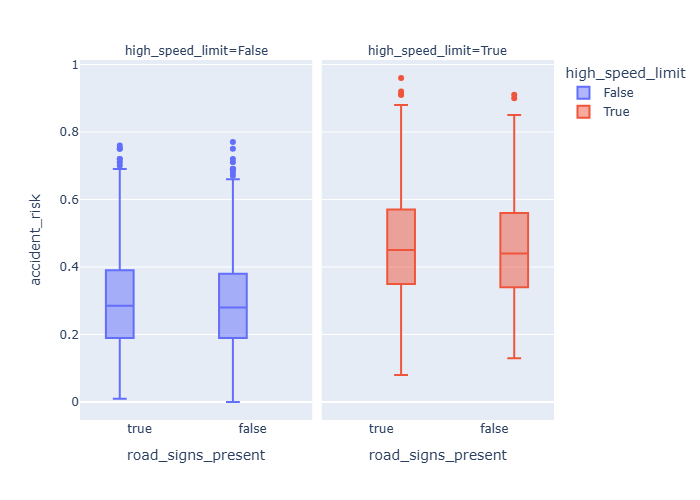

Column: public_road


public_road,false,true
bool,f64,f64
true,0.295448,0.462862
false,0.286253,0.455956


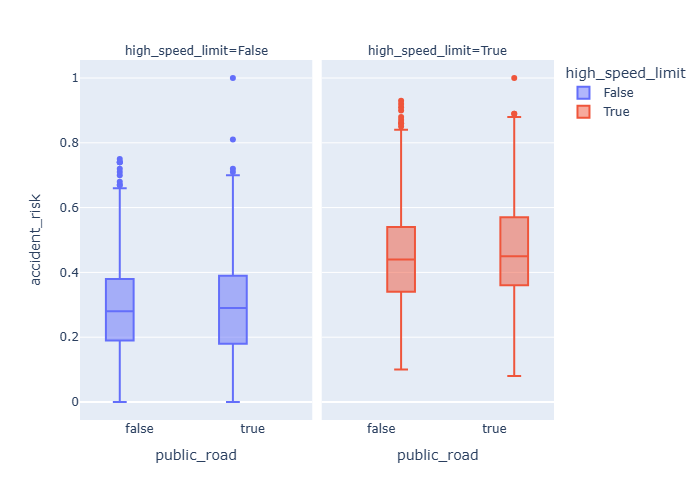

Column: holiday


holiday,true,false
bool,f64,f64
false,0.453106,0.282684
true,0.465554,0.299021


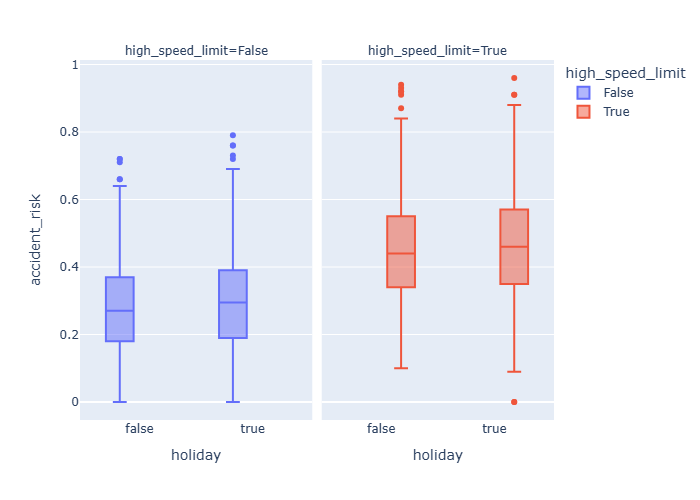

Column: school_season


school_season,false,true
bool,f64,f64
true,0.290702,0.458363
false,0.290955,0.460597


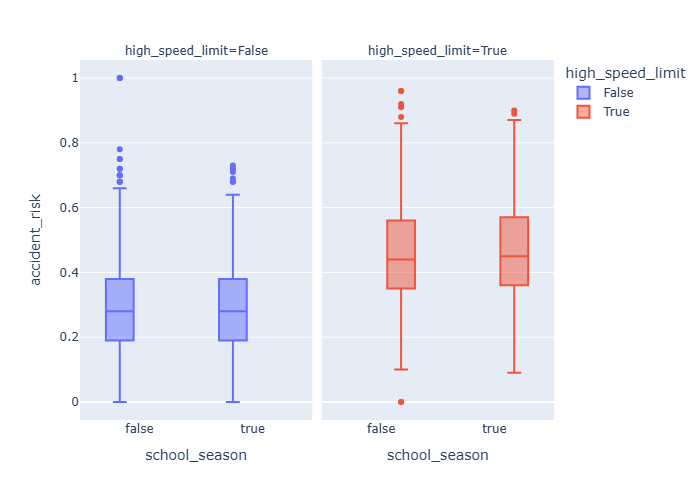

In [22]:
new_train = train.with_columns((pl.col("speed_limit") > 50).alias("high_speed_limit"))
# Baseline high speed limit effects
display(
    new_train.group_by("high_speed_limit").agg(
        (pl.col(y_col).mean()).alias("Mean accident rate")
    )
)
# Combining high speed limit with each categorical var
for col in cat_cols:
    print(f"Column: {col}")
    display(
        new_train.group_by(["high_speed_limit", col])
        .agg((pl.col(y_col).mean()).alias("mean_accident_rate"))
        .pivot(index=col, on="high_speed_limit", values="mean_accident_rate")
    )
    px.box(
        new_train.sample(n=SAMPLE_SIZE),
        x=col,
        y=y_col,
        facet_col="high_speed_limit",
        color="high_speed_limit",
    ).show()

- Doesn't seem to be any interaction between high speed limit and the categorical variables.
- I did experimented with some interactions and the following seemed to work a little.

In [23]:
new_train = train.with_columns(
    [
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
);

Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.003755544053204532
The model improves by 0.0016461658603379279 (30.47%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031517879735128477
The model improves by 7.905408294034758e-07 (0.03%)


- The only features that I've tried so far that actually helped XGBoost.
- Possible explanation: some effects of this interaction may not be fully captured by xgboost
- Note: the baseline xgboost is already close to Kaggle leaderboard top performances; 0.03% should not be disregarded as minor
- **New Feature:** speed_limit > 50 & lighting == night (high_speed_night)

## Curvature ^ 2

In [24]:
new_train = train.with_columns((pl.col("curvature") ** 2).alias("curve_squared"))
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
);

Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.005400133937833818
The model improves by 1.5759757086416734e-06 (0.03%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031527351043748077
The model degrades by 1.5659003255652157e-07(0.00%)


- Only see very mild improvement for Ridge Regression.
- Decide later if curvature ^ 2 should be included.

## Dropping columns

In [25]:
new_train = train.drop(["num_lanes", "road_signs_present", "school_season"])
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
);

Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.005402514258621395
The model degrades by 8.043450789351272e-07(0.01%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031535465237644634
The model degrades by 9.68009422212205e-07(0.03%)


- Overall worse, indicating even though these are weak prodictors, they likely contain some minimal predicting power.

## Try curvature ^ 2 with other features

In [26]:
# combining all features together
print("Include Curvature ^ 2")
new_train = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
        (pl.col("curvature") ** 2).alias("curvature_squared"),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
)
print("NOT include Curvature ^ 2")
new_train = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)
print("Ridge model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
print("XGBoost model:")
EDA.cv_score_improvement_by_new_features(
    new_X, X, y, xgb_model, "neg_mean_squared_error"
);


Include Curvature ^ 2
Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.003366702917714877
The model improves by 0.002035006995827583 (37.67%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031517879735128477
The model improves by 7.905408294034758e-07 (0.03%)
NOT include Curvature ^ 2
Ridge model:
Baseline score: -0.00540170991354246
Score with new features: -0.0033670571899281554
The model improves by 0.0020346527236143044 (37.67%)
XGBoost model:
Baseline score: -0.003152578514342251
Score with new features: -0.0031517879735128477
The model improves by 7.905408294034758e-07 (0.03%)


- Practically the same performances for both models.
- NOT include curvature ^ 2

## Final features

- Every original features +
- abnormal_reported: num_reported_accidents >= 3
- high_speed_limit: speed_limit > 50
- high_speed_night: speed_limit > 50 & lighting == night

Baseline score: -0.00540170991354246
Score with new features: -0.0033670571899281554
The model improves by 0.0020346527236143044 (37.67%)


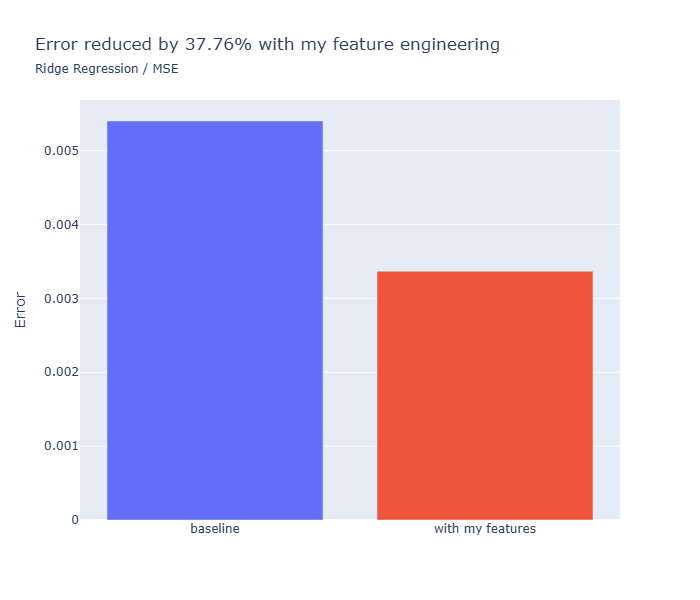

In [42]:
new_train = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)
baseline_MSE, new_MSE = EDA.cv_score_improvement_by_new_features(
    new_X, X, y, ridge_model, "neg_mean_squared_error"
)
performances = pl.DataFrame(
    {
        "features": ["baseline", "with my features"],
        "value": [-baseline_MSE, -new_MSE],
    }
)
fig = px.bar(
    data_frame=performances,
    x="features",
    y="value",
    color="features",
    title="Error reduced by 37.76% with my feature engineering",
    subtitle="Ridge Regression / MSE",
    height=600,
)
fig.update_xaxes(title="")
fig.update_yaxes(title="Error")
fig.update_layout(showlegend=False)
fig.show()
fig.write_image(PLOT_FOLDER / "performance_comparison.png")

# Tune Hyperparameters

In [43]:
# Use final full features
new_train = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)

# xgboost with full dataset
# Define hyperparameter grid
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}

xgb_model = XGBRegressor(
    random_state=42,
)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
)

# Fit the grid search
grid_search.fit(new_X, y)

# Get results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model
best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: -0.05603342723801273


## Best XGBoost parameters
- learning_rate: 0.05
- max_depth: 7
- n_estimators: 300
- subsample: 0.8

In [44]:
# Use the best features so far
new_train = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_train, y_col)
# Ridge Regression with full dataset
# Define hyperparameter grid
param_grid = {"alphas": [0.1, 0.25, 0.5, 0.75, 1, 2]}

model = RidgeCV()

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kfold,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2,
)

# Fit the grid search

grid_search.fit(new_X, y)

# Get results
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model
best_ridge_model = grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'alphas': 1}
Best cross-validation score: -0.058026208222435004


## Best Ridge Regression parameters
- alpha: 1

In [45]:
# Saving the models
joblib.dump(best_ridge_model, MODELS_FOLDER / "ridge_model.joblib")
joblib.dump(best_xgb_model, MODELS_FOLDER / "xgb_model.joblib")

['..\\models\\xgb_model.joblib']

## Conclusion
- We improved Ridge Regression so much through feature engineering that it reached similar MSE as XGboost model, which means we've identified the non-linear predictors manually.
- In practice, I might favor Ridge Regression for its speed and interpretability, espeically since its performance is closely behind behind that of XGBoost.
- In situations where accuracy is top priority, XGBoost is still preferred here.

# Making predictions

In [46]:
test = pl.read_csv(DATA_FOLDER / "test.csv")

In [47]:
# ridge model output
new_test = test.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_test, y_col, test_set=True)
ridge_pred = best_ridge_model.predict(new_X)
ridge_output = pl.DataFrame({"id": test.select("id"), "accident_risk": ridge_pred})
ridge_output.write_parquet("../prediction/ridge_submission.parquet")

In [48]:
# xgboost model output
new_test = test.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
new_X = EDA.make_new_X(new_test, y_col, test_set=True)
xgb_pred = best_xgb_model.predict(new_X)
xgb_output = pl.DataFrame({"id": test.select("id"), "accident_risk": xgb_pred})
xgb_output.write_parquet("../prediction/xgb_submission.parquet")

## Result (from Kaggle website):
1. Ridge Model RMSE on test set: 0.05771
2. XGBoost Model RMSE on test set: 0.05555
3. Best ranking: Top 25%

# Interpret Ridge Regression coefficients

In [49]:
# Prepare data for coefficient interpretation
df = train.with_columns(
    [
        (pl.col("num_reported_accidents") >= 3).alias("abnormal_reports"),
        (pl.col("speed_limit") > 50).alias("high_speed_limit"),
        ((pl.col("speed_limit") > 50) & (pl.col("lighting") == "night")).alias(
            "high_speed_night"
        ),
    ]
)
cat = df.select([cs.string(), cs.boolean()]).columns
df = df.drop(["id", y_col]).to_dummies(cat)

In [50]:
# load Ridge Regression model
model = joblib.load(MODELS_FOLDER / "ridge_model.joblib")
feature_names = ["intercept"] + df.columns
coefficient = model.intercept_.tolist() + model.coef_.tolist()
coef_df = pl.DataFrame({"features": feature_names, "coef": coefficient})

In [51]:
pred = model.predict(df.to_numpy())
r2 = r2_score(y, pred)
rmse = root_mean_squared_error(y, pred)
display(f"RMSE: {round(rmse, 5)}")
display(f"R2: {round(r2, 2)}")

'RMSE: 0.05802'

'R2: 0.88'

## R^2 on train set: 88%
- My regression model explains 88% of the variability

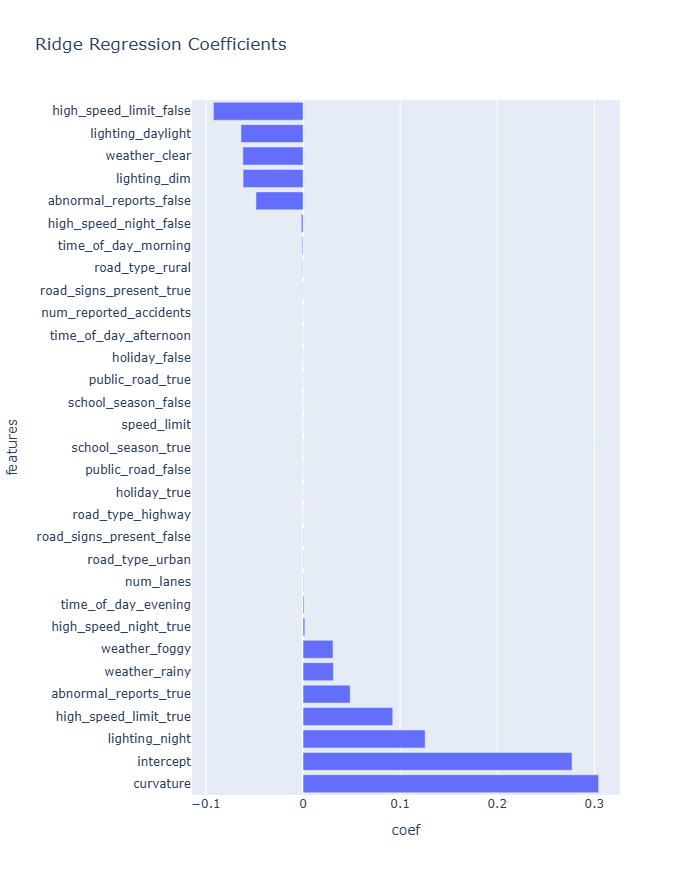

In [52]:
plot_height = len(coef_df) * 25 + 100
fig = px.bar(
    coef_df.sort("coef", descending=True),
    x="coef",
    y="features",
    orientation="h",
    height=plot_height,
    title="Ridge Regression Coefficients",
)
fig.update_yaxes(dtick=1)
fig.show()
fig.write_image(PLOT_FOLDER / "coefficients.png")

## Key observations:
1. Positive coefficients:
- Curvature (0.30): greatest contributor to accident risk
- Intercept (0.28): high baseline accident risk
- Lighting - night (0.13)
- High Speed Limit - True (> 50) (0.09): a better indicator than pure numeric speed limit
- Abnormal Reported Accidents - True (>= 3) (0.05): a better indicator than numeric number of accidents reported
- Weather - raining/foggy (0.03): similar effects, moderate increase in accidents
2. Negative coefficients:
- High Speed Limit - False (-0.09): best indicator to lower accident risks
- Lighting - Daylight (-0.06)
- Weather - Clear (-0.06)
- Lighting - Dim (-0.06): could be due to dim light causing drivers to drive more carefully
- Abnormal Reported - False (-0.05)
3. Almost all significant variables make intuitive sense. Feature engineering helps make the model perform better and more interpretable.
4. Multicollinearity issues are not present as the sample size is huge (> 500k rows)

## Residual Analysis

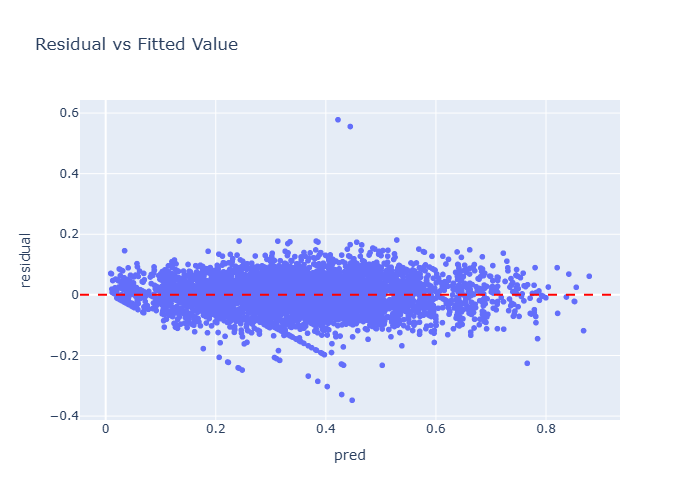

In [53]:
# Calculate residuals
res_df = pl.DataFrame({"y": y.ravel(), "pred": pred})
res_df = res_df.with_columns((pl.col("y") - pl.col("pred")).alias("residual"))
# Plot them
fig = px.scatter(
    data_frame=res_df.sample(n=SAMPLE_SIZE),
    x="pred",
    y="residual",
    title="Residual vs Fitted Value",
)
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()
fig.write_image(PLOT_FOLDER / "residuals.png")

- Apart from certain outliters, the residuals have expected value 0 and equal variance throughout.
- This shows the Ridge Regression model is well fitted. Assumptions are satisfied.